<a href="https://colab.research.google.com/github/biditdas18/Generative_Adversarial_Network_Fake_Celebrity_Faces/blob/master/covid_Train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/My Drive/covid detection

/content/drive/My Drive/covid detection


In [ ]:
pwd

'/content/drive/My Drive/covid detection'

In [ ]:
!ls

covid_model.h5	covid_Train_model.ipynb  data


In [ ]:
import argparse
from imutils import paths
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Flatten, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,\
    preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


from glob import glob

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys,os

In [ ]:
# Grab the list of images in the data directory and initialize the data list
# and the class labels list
imagePaths = list(paths.list_images('data'))
data = []
labels = []

In [ ]:
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))

    data.append(image)
    labels.append(label)

data = np.array(data)/255.0
labels = np.array(labels)
labels

array(['normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxray',
       'normal_chestxray', 'normal_chestxray', 'normal_chestxr

In [ ]:
# perform one hot encoding of the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [ ]:
# partition the data into training and testing splits using 80% of the data for training
# and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# define the pretrained model
ptm = PretrainedModel(
    input_shape=(224,224,3),
    weights = 'imagenet',
    include_top = False
)

In [ ]:
# freeze pretrained model
ptm.trainable = False

In [ ]:
# Keras image data generator returns classes one-hot encoded
# define the model
x = ptm.output
x = AveragePooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=ptm.input, outputs=x)

# view the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
    rotation_range=20,
    fill_mode = 'nearest',
)

# gen_test = ImageDataGenerator(
#     preprocessing_function=preprocess_input
# )

In [ ]:
batch_size = 8

# create generators
train_generator = gen_train.flow(
    trainX, trainY, shuffle=True, batch_size=batch_size)

# valid_generator = gen_test.flow(
#     testX,testY, batch_size=batch_size)
LR = 0.001
EPOCHS = 40
opt = Adam(lr=LR, decay=0.001 / EPOCHS)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer= opt,
    metrics=['accuracy']
)

In [ ]:
# fit the model
r = model.fit_generator(
    train_generator,
    validation_data=(testX,testY),
    epochs=EPOCHS,
    steps_per_epoch=int(np.ceil(len(trainX)/batch_size)),
    validation_steps=int(np.ceil(len(testX)/batch_size))
)

Epoch 1/40
42/42 [==============================] - 7s 165ms/step - loss: 0.6589 - accuracy: 0.6257 - val_loss: 0.4559 - val_accuracy: 0.9643
Epoch 2/40
42/42 [==============================] - 7s 159ms/step - loss: 0.3898 - accuracy: 0.8623 - val_loss: 0.3169 - val_accuracy: 0.9286
Epoch 3/40
42/42 [==============================] - 7s 159ms/step - loss: 0.2804 - accuracy: 0.9162 - val_loss: 0.2344 - val_accuracy: 0.9405
Epoch 4/40
42/42 [==============================] - 7s 161ms/step - loss: 0.2171 - accuracy: 0.9371 - val_loss: 0.2084 - val_accuracy: 0.9405
Epoch 5/40
42/42 [==============================] - 7s 162ms/step - loss: 0.1824 - accuracy: 0.9491 - val_loss: 0.1495 - val_accuracy: 0.9524
Epoch 6/40
42/42 [==============================] - 7s 161ms/step - loss: 0.1704 - accuracy: 0.9401 - val_loss: 0.1951 - val_accuracy: 0.9167
Epoch 7/40
42/42 [==============================] - 7s 161ms/step - loss: 0.1701 - accuracy: 0.9341 - val_loss: 0.1465 - val_accuracy: 0.9524
Epoch 

In [ ]:
# Predictions
pred = model.predict(testX,batch_size=batch_size)
pred.shape

(84, 2)

In [ ]:
trainX.shape

(334, 224, 224, 3)

In [ ]:
testX.shape

(84, 224, 224, 3)

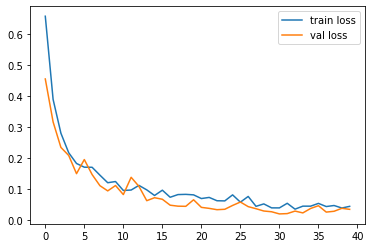

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

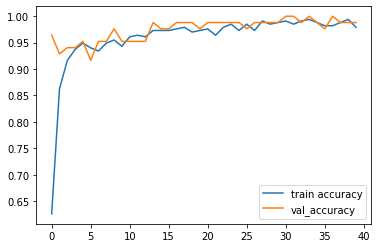

In [ ]:
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap=plt.cm.Blues):
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  


  fmt= '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()





Confusion matrix, without normalization
[[40  1]
 [ 0 43]]


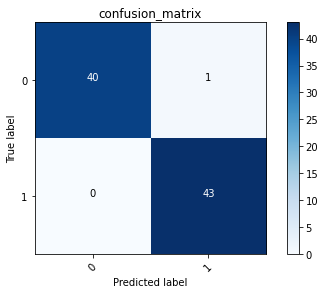

In [ ]:
p_test = model.predict(testX).argmax(axis=1)
testY = testY.argmax(axis=1)
cm = confusion_matrix(testY, p_test)
plot_confusion_matrix(cm, list(range(2)))

In [ ]:
cm = confusion_matrix(testY, p_test)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[40  1]
 [ 0 43]]
acc: 0.9881
sensitivity: 0.9756
specificity: 1.0000


In [ ]:
model.save('covid_model.h5')